In [409]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [410]:
# Load files
file_path_hist_gpcd = "gpcd_hist_gville_county.csv"  
file_path_hist_pre = "pre_hist_gville_county.csv" 
file_path_hist_temp = "temp_hist_gville_county.csv"  
file_path_hist_pop = "pop_hist_gville_county.csv"  
pre = pd.read_csv(file_path_hist_pre)
temp = pd.read_csv(file_path_hist_temp)
pop = pd.read_csv(file_path_hist_pop)
gpcd = pd.read_csv(file_path_hist_gpcd)



In [411]:
# Set constants
start_year = 1985
end_year = 2015


In [412]:
# 1. Preprocessing Population Data

# Interpolate population from the 'pop' sheet
# Ensure the column names are correct
pop.columns = ['year', 'pop']

pop = pop[(pop['year'] >= start_year) & (pop['year'] <= end_year)]
pop.reset_index(drop=True, inplace=True) 

rows = []

# Create a DataFrame with all months
result = pd.DataFrame(columns=['year', 'month', 'pop'])

# Iterate through each year and interpolate monthly data
for i in range(len(pop) - 1):
    s_year = pop.loc[i, 'year']
    e_year = pop.loc[i + 1, 'year']
    start_pop = pop.loc[i, 'pop']
    end_pop = pop.loc[i + 1, 'pop']
    
    # Generate monthly data
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_pops = np.linspace(start_pop, end_pop, 12, endpoint=False)
    monthly_pops = np.round(monthly_pops).astype(int)  # Round to whole numbers
    
    # Append to result DataFrame
    for j, month in enumerate(months):
        rows.append({'year': s_year, 'month': month, 'pop': monthly_pops[j]})
        
# Add data for the final year
last_year = pop.loc[len(pop) - 1, 'year']
last_pop = pop.loc[len(pop) - 1, 'pop']
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        rows.append({'year': last_year, 'month': month, 'pop': last_pop})
        
result = pd.DataFrame(rows)

pop = result
pop = pop.reset_index(drop=True)

#display(pop)


In [413]:
# Preprocessing Precipitation Data

pre = pre.drop(columns=["ANNUAL"])

#Filter precipitation for the time range
pre['YEAR'] = pd.to_numeric(pre['YEAR'], errors='coerce')

pre = pre[(pre['YEAR'] >= start_year) & (pre['YEAR'] <= end_year)] 
#pre.set_index('YEAR', inplace=True)

# Reshape the data from wide to long format
pre_long = pre.melt(id_vars=["YEAR"], var_name="month", value_name="pre")


# Map month columns (M1, M2, ...) to actual month names
month_map = {
    "M1": "Jan", "M2": "Feb", "M3": "Mar", "M4": "Apr", "M5": "May",
    "M6": "Jun", "M7": "Jul", "M8": "Aug", "M9": "Sep", "M10": "Oct",
    "M11": "Nov", "M12": "Dec"
}
pre_long["month"] = pre_long["month"].map(month_map)



# Filter out rows where 'pre' is "M"
pre_long = pre_long[pre_long["pre"] != "M"]

# Rename columns for clarity
pre_long = pre_long.rename(columns={"YEAR": "year"})

# Reset index for a clean output
pre_long = pre_long.reset_index(drop=True)
pre = pre_long


#display(pre)



In [414]:
# 2. PreProcessing GPCD

gpcd = gpcd[(gpcd['year'] >= start_year) & (gpcd['year'] <= end_year)]
gpcd = gpcd.set_index('year')
gpcd = gpcd.iloc[:, [-1]]
gpcd.rename(columns={gpcd.columns[0]: 'gpcd'}, inplace=True)

full_year_range = list(range(start_year, end_year+1))

# Step 2: Add missing years (insert rows for missing years)
gpcd = gpcd.reindex(full_year_range)

# Step 3: Fill missing gpcd values with blank (empty) values
gpcd['gpcd'] = gpcd['gpcd'].replace(np.nan, '')

# Step 4: Create a new DataFrame with a 'month' column
month_list = []

# Mapping month numbers to their three-character abbreviations
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# For each year, create rows for each month (Jan-Dec)
for year in full_year_range:
    for month in range(1, 13):
        month_list.append({'year': year, 'month': month_map[month], 'gpcd': ''})

# Convert this list to a DataFrame
monthly_df = pd.DataFrame(month_list)

# Step 5: Merge the monthly_df with the gpcd_df to assign gpcd values for December
# We will assign the existing gpcd values to December rows for each year.
for year in full_year_range:
    december_row = monthly_df[(monthly_df['year'] == year) & (monthly_df['month'] == 'Dec')]
    if pd.notna(gpcd.loc[year, 'gpcd']):
        monthly_df.loc[december_row.index, 'gpcd'] = gpcd.loc[year, 'gpcd']

# Step 6: Print the resulting DataFrame
gpcd = monthly_df
gpcd = gpcd.reset_index(drop=True)
#display(gpcd)

In [415]:
# Preprocess temperature data

temp = temp.drop(columns=["ANNUAL"])

#Filter precipitation for the time range
temp['YEAR'] = pd.to_numeric(temp['YEAR'], errors='coerce')

temp = temp[(temp['YEAR'] >= start_year) & (temp['YEAR'] <= end_year)] 
#pre.set_index('YEAR', inplace=True)

# Reshape the data from wide to long format
temp_long = temp.melt(id_vars=["YEAR"], var_name="month", value_name="temp")


# Map month columns (M1, M2, ...) to actual month names
month_map = {
    "M1": "Jan", "M2": "Feb", "M3": "Mar", "M4": "Apr", "M5": "May",
    "M6": "Jun", "M7": "Jul", "M8": "Aug", "M9": "Sep", "M10": "Oct",
    "M11": "Nov", "M12": "Dec"
}
temp_long["month"] = temp_long["month"].map(month_map)



# Filter out rows where 'pre' is "M"
temp_long = temp_long[temp_long["temp"] != "M"]

# Rename columns for clarity
temp_long = temp_long.rename(columns={"YEAR": "year"})

# Reset index for a clean output
temp_long = temp_long.reset_index(drop=True)
temp = temp_long

#display(temp)



In [416]:
# Merge all data into one df

# Merge all DataFrames based on 'year' and 'month'
hist_df = gpcd.merge(pop, on=['year', 'month'], how='outer', suffixes=('_gpcd', '_pop'))
hist_df = hist_df.merge(pre, on=['year', 'month'], how='outer')
hist_df = hist_df.merge(temp, on=['year', 'month'], how='outer')

#  Fill  values with blank (empty) values
hist_df['gpcd'] = hist_df['gpcd'].replace(np.nan, '')
hist_df['pre'] = hist_df['pre'].replace(np.nan, '')
hist_df['temp'] = hist_df['temp'].replace(np.nan, '')

hist_df['gpd'] = hist_df['gpcd'] * hist_df['pop']

#display(hist_df)

In [417]:
# Calculate Annual GPD

# 1. Filter for December of each year
december_data = hist_df[hist_df['month'] == 'Dec'].copy()
december_data.loc[:, 'gpd'] = pd.to_numeric(december_data['gpd'], errors='coerce')


# 2. Prepare the training data (drop rows where 'gpd' is NaN)
train_data = december_data.dropna(subset=['gpd'])


# 3. Define the independent variables (X) and dependent variable (y)
X_train = train_data[['year', 'temp', 'pre']]  # Independent variables
y_train = train_data['gpd']  # Dependent variable

# 4. Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Predict 'gpd' for all December rows, including those with missing 'gpd'
X_predict = december_data[['year', 'temp', 'pre']]  # Same features for prediction
december_data['predicted_gpd'] = model.predict(X_predict).round().astype(int)

# Set pandas options to display full numbers
pd.set_option('display.float_format', '{:.0f}'.format)

#display data
#print(december_data)

# 6.  replace missing 'gpd' values with the predicted ones
hist_df.loc[hist_df['month'] == 'Dec', 'gpd'] = december_data['predicted_gpd']

#make sure value numeric
hist_df['gpd'] = pd.to_numeric(hist_df['gpd'], errors='coerce')

hist_df['gpd'] = hist_df['gpd'].clip(lower=0)





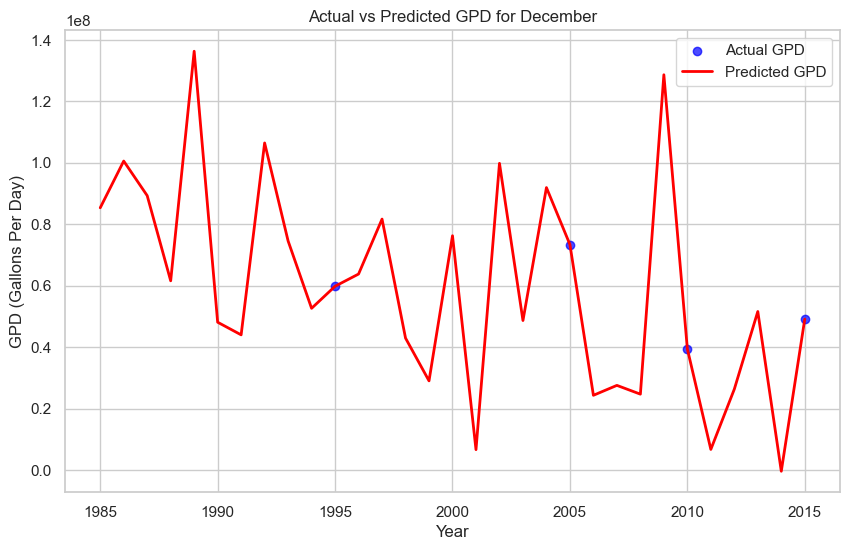

In [418]:
# Extract actual and predicted data
X_plot = december_data[['year', 'temp', 'pre']]
y_actual = december_data['gpd']
y_predicted = model.predict(X_plot).round().astype(int)

# Scatter plot of actual GPD
plt.figure(figsize=(10, 6))
plt.scatter(december_data['year'], y_actual, color='blue', label='Actual GPD', alpha=0.7)

# Line plot of predicted GPD
plt.plot(december_data['year'], y_predicted, color='red', label='Predicted GPD', linewidth=2)

# Labels and title
plt.xlabel('Year')
plt.ylabel('GPD (Gallons Per Day)')
plt.title('Actual vs Predicted GPD for December')
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [419]:
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Add a new column to convert month abbreviations to numeric values
hist_df['month_num'] = hist_df['month'].map(month_map)

# Replace empty strings with NaN in relevant columns
hist_df['gpd'].replace('', np.nan, inplace=True)

# Convert month into cyclical features
hist_df['month_sin'] = np.sin(2 * np.pi * hist_df['month_num'].astype(int) / 12)
hist_df['month_cos'] = np.cos(2 * np.pi * hist_df['month_num'].astype(int) / 12)

# 2. Prepare the training data (drop rows where 'gpd' is NaN)
train_data = hist_df.dropna(subset=['gpd'])

# 3. Define the independent variables (X) and dependent variable (y)
X_train = train_data[['year', 'temp', 'pre', 'month_sin', 'month_cos']]  # Add cyclical features
y_train = train_data['gpd']  # Dependent variable

# 4. Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Predict 'gpd' for all rows, including those with missing 'gpd'
X_predict = hist_df[['year', 'temp', 'pre', 'month_sin', 'month_cos']]  # Same features for prediction
hist_df['predicted_gpd'] = model.predict(X_predict).round().astype(int)

# 6. Replace missing 'gpd' values with the predicted ones
hist_df['gpd'].fillna(hist_df['predicted_gpd'], inplace=True)


#make sure value numeric
hist_df['gpd'] = pd.to_numeric(hist_df['gpd'], errors='coerce')

#remove values below 0
hist_df['gpd'] = hist_df['gpd'].clip(lower=0)


# Display the updated DataFrame
#print(december_data)

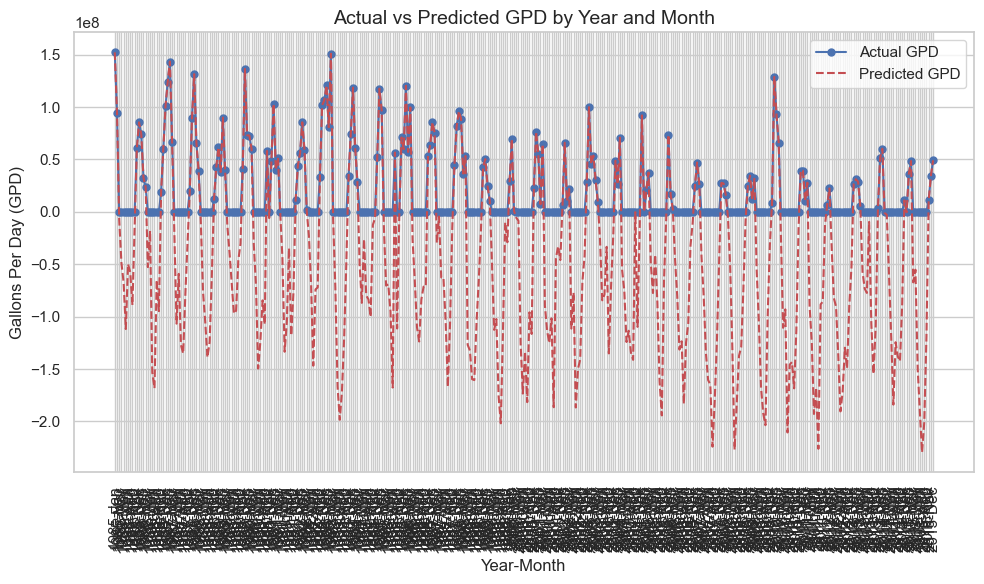

In [420]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot actual 'gpd' values
plt.plot(hist_df['year'].astype(str) + '-' + hist_df['month'], hist_df['gpd'], label='Actual GPD', color='b', marker='o', linestyle='-', markersize=5)

# Plot predicted 'gpd' values
plt.plot(hist_df['year'].astype(str) + '-' + hist_df['month'], hist_df['predicted_gpd'], label='Predicted GPD', color='r', linestyle='--', markersize=5)

# Set the title and labels
plt.title('Actual vs Predicted GPD by Year and Month', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Gallons Per Day (GPD)', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [421]:
# calculate the gpcd

# Only divide 'gpd' by 'pop' where 'gpd' is not 0
hist_df['gpcd'] = hist_df.apply(lambda row: row['gpd'] / row['pop'] if row['gpd'] != 0 else 0, axis=1)

# Display the updated DataFrame 
#display(hist_df)

In [422]:
# 7. Save Results to Excel
output_path = "regression_input_data.csv"

#drop the columns we dont need anymore
hist_df = hist_df.drop(columns=['predicted_gpd'])
hist_df = hist_df.drop(columns=['month_sin'])
hist_df = hist_df.drop(columns=['month_cos'])
hist_df = hist_df.drop(columns=['month_num'])



# Export the DataFrame to an csv
hist_df.to_csv(output_path, index=False)

print(f"Results saved to {output_path}")

Results saved to regression_input_data.csv
